Use GPyTorch
Use Spectral Mixture kernel

In [1]:
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [7]:
df = pd.read_csv("../data/sim_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [8]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

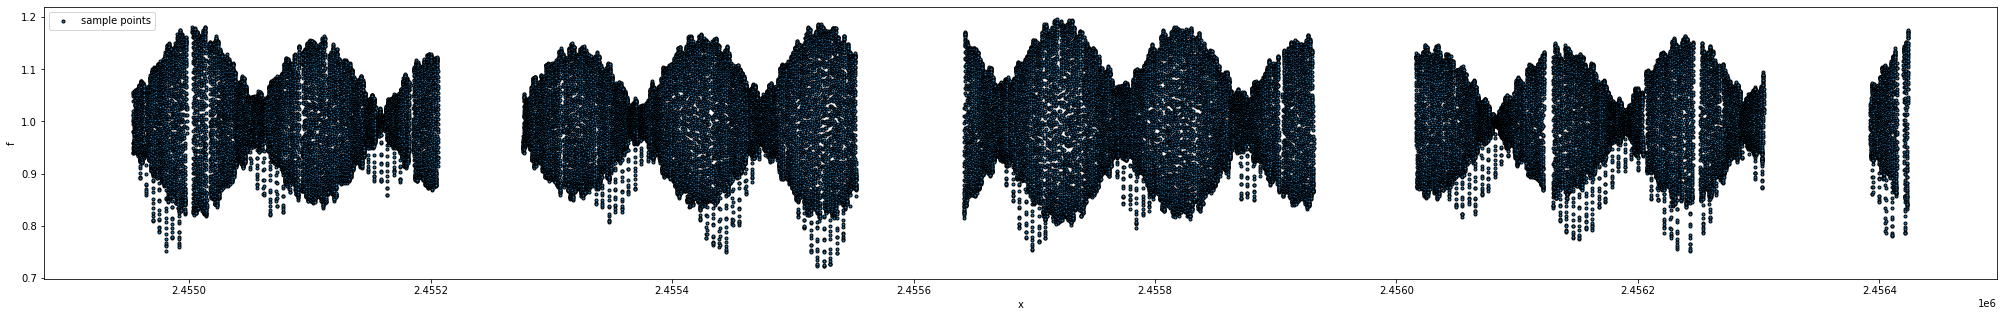

In [9]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

Zoomed in on the first N observations

In [10]:
frequency, power = LombScargle(X, Y).autopower(minimum_frequency=-0, maximum_frequency=5)
frequency, power

(array([0.00000000e+00, 1.36011628e-04, 2.72023257e-04, ...,
        4.99978746e+00, 4.99992347e+00, 5.00005948e+00]),
 array([           inf, 7.17450556e-06, 7.48383761e-06, ...,
        8.08948941e-08, 6.08853151e-08, 6.79813574e-08]))

(Text(0.5, 0, 'frequency'), Text(0, 0.5, 'power'))

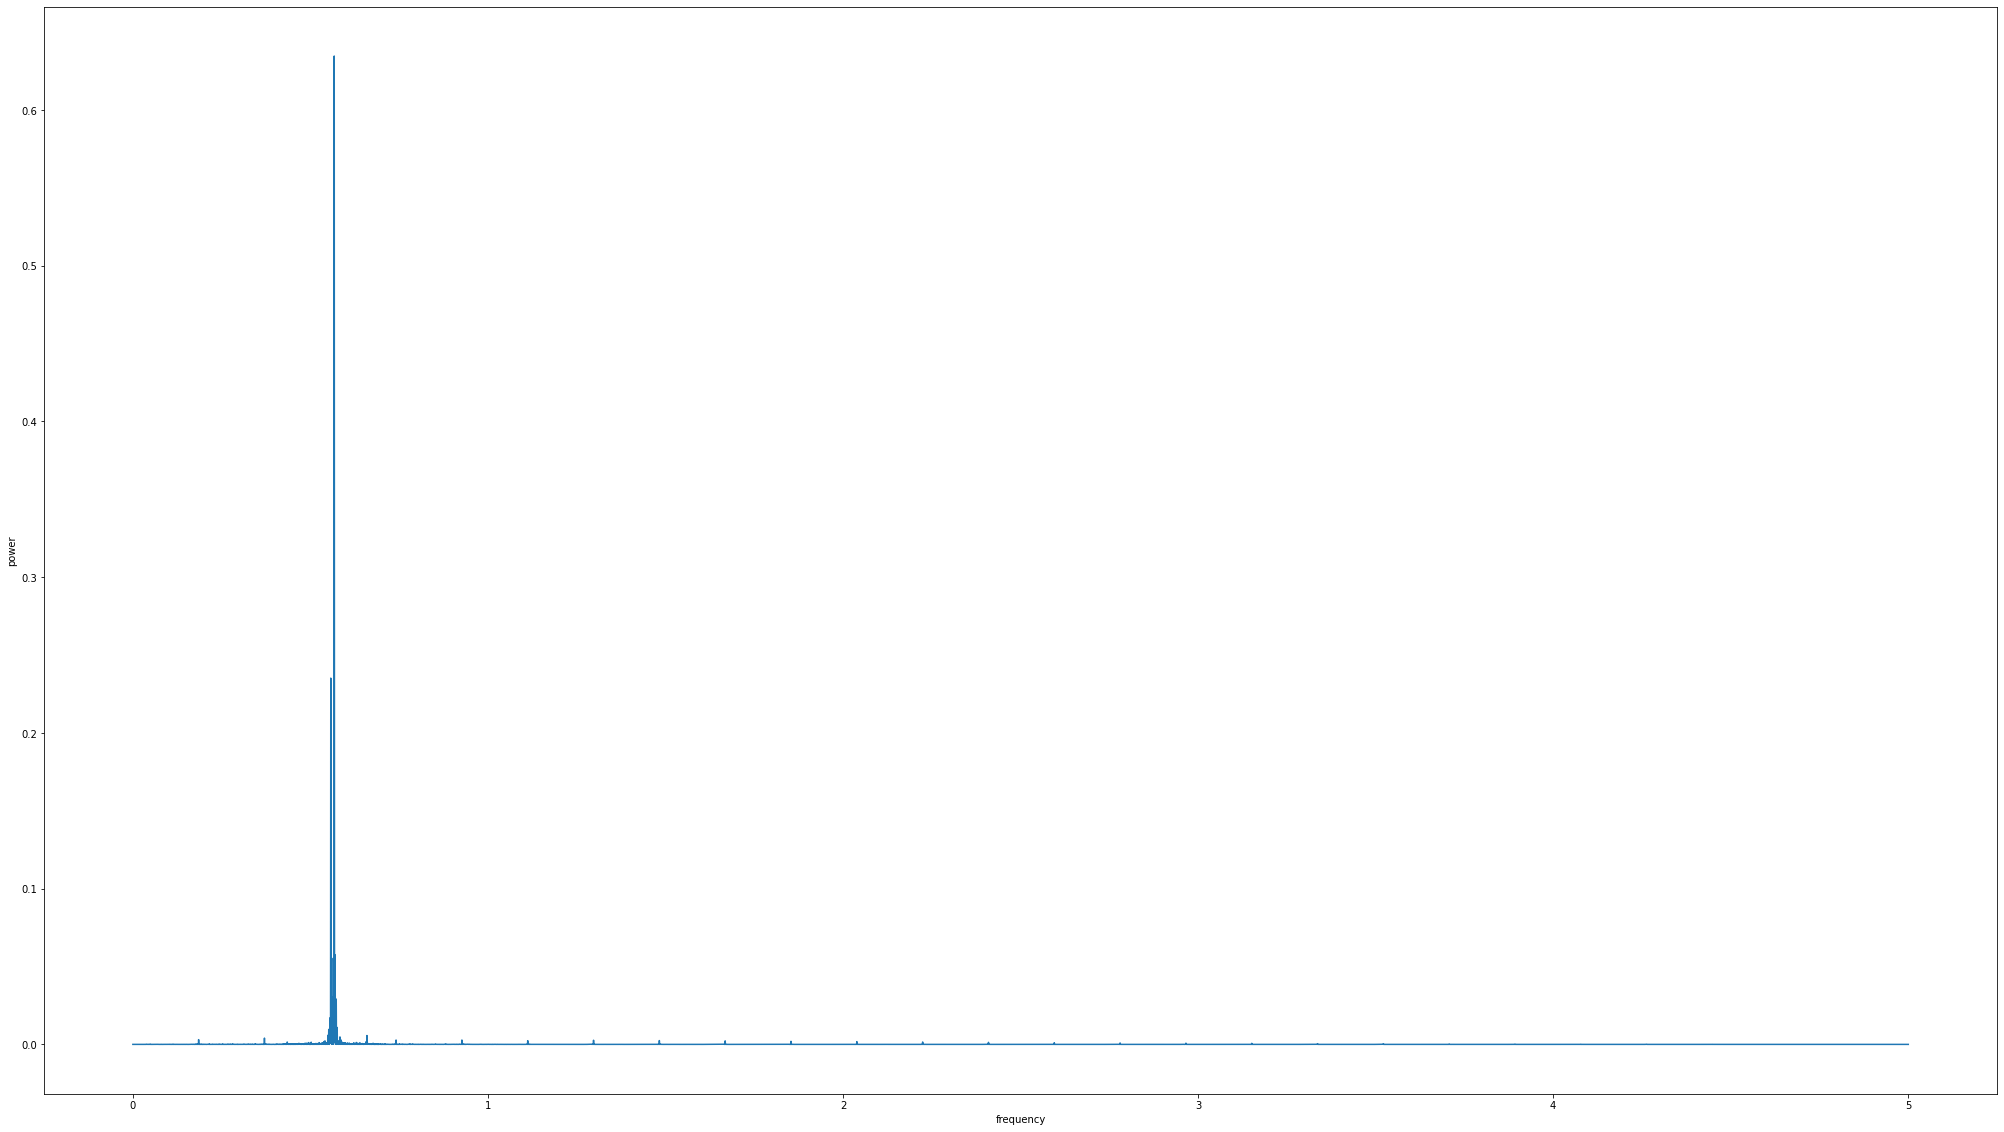

In [13]:
plt.figure(figsize=(35, 20))
plt.plot(frequency, power)
plt.xlabel("frequency"), plt.ylabel("power")

In [14]:
N_part=5000

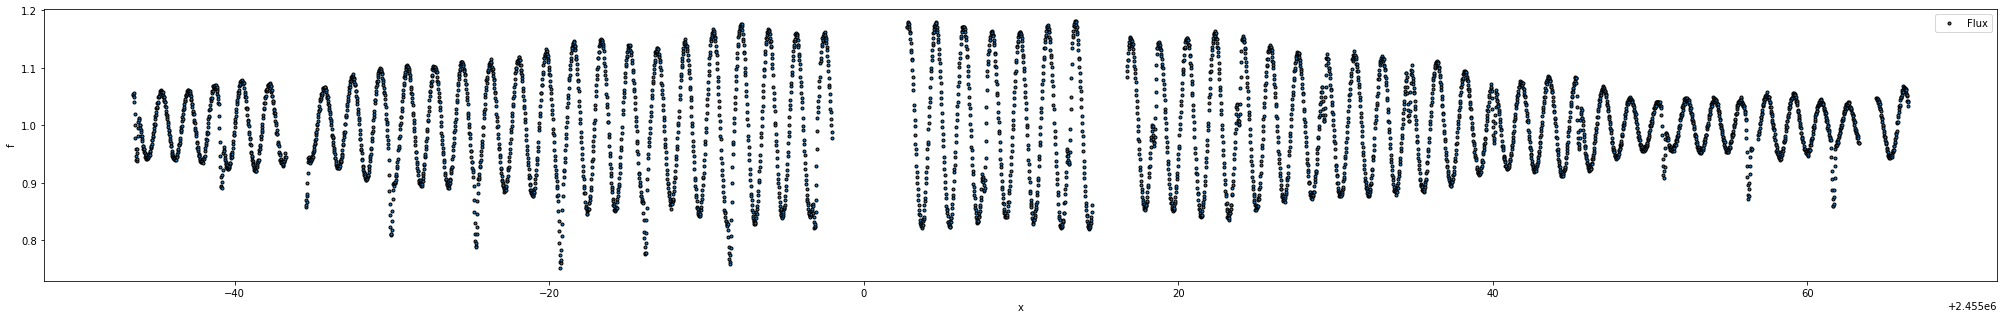

In [15]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X[:N_part], Y[:N_part], ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [16]:
def plot_kernel_samples(model, x, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    for i in range(nr_of_samples):
        Y_sample = model(x).sample()
        N = Y_sample.shape[0]
        plt.plot(range(N), Y_sample)

def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        if not var is None:
            plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    
def plot_1d_kernel(kernel):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Predict evenly spaced points on our time-axis
    x = np.linspace(-6, 6, 1000)
    y = kernel.eval(x)
    
    # Plot observations
    plt.plot(x, y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])

def eval_2d(x):
    return np.array([x-i for i in x.tolist()])
    
def plot_2d_kernel(kernel):
    # Our sample space
    x = np.linspace(-5., 5., 250)
    grid = eval_2d(x)
    C = kernel.eval(grid)

    # Visualise covariance matrix on right hand side
    plt.pcolor(x.T, x, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

In [17]:
X_part=torch.tensor(X[:N_part])
Y_part=torch.tensor(Y[:N_part])

In [18]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [19]:
# normalize labels
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

In [20]:
X_part,Y_part

(tensor([2454953.5392, 2454953.5597, 2454953.5801,  ..., 2455066.3955,
         2455066.4159, 2455066.4363], dtype=torch.float64),
 tensor([0.6505, 0.6754, 0.6984,  ..., 0.5358, 0.5131, 0.4378],
        dtype=torch.float64))

(Text(0.5, 0, 'frequency'), Text(0, 0.5, 'power'))

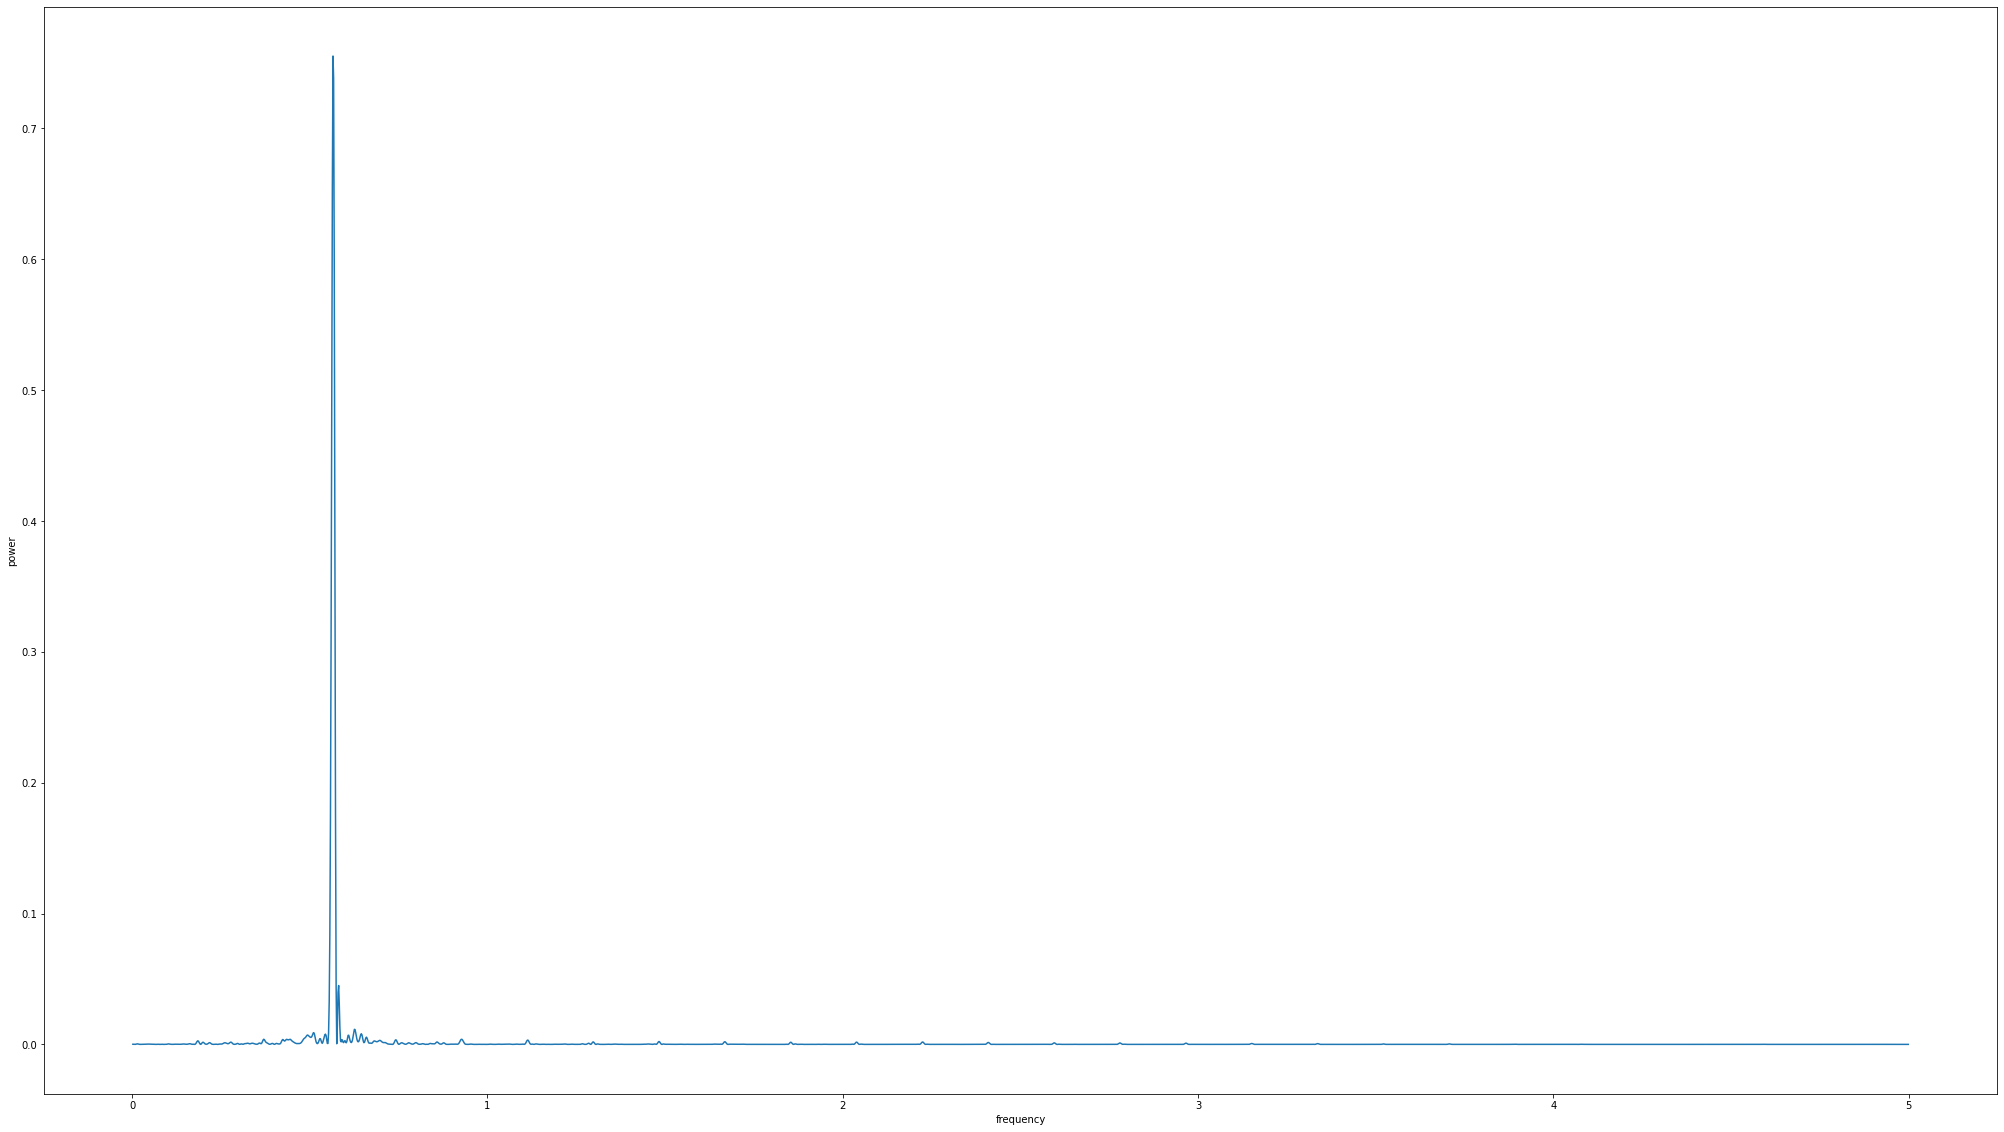

In [22]:
frequency, power = LombScargle(X_part, Y_part).autopower(minimum_frequency=0.0, maximum_frequency=5)
frequency, power
plt.figure(figsize=(35, 20))
plt.plot(frequency, power)
plt.xlabel("frequency"), plt.ylabel("power")

In [23]:
Y_part.cpu().numpy().mean()

-1.121236437029438e-15

In [24]:
NUM_MIXTURES=25

In [25]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
#        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
#        self.covar_module = gpytorch.kernels.RBFKernel()
#        self.covar_module.lengthscale = 0.1
#        self.covar_module = gpytorch.kernels.ScaleKernel(self.covar_module)
        self.covar_module = gpytorch.kernels.PeriodicKernel()
        self.covar_module.period_length = 1.7
        self.covar_module = gpytorch.kernels.ScaleKernel(self.covar_module)
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=NUM_MIXTURES)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = ExactGPModel(X_part, Y_part, likelihood)
model = SpectralMixtureGPModel(X_part, Y_part, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

Move data and models to the GPU

In [26]:
if USE_CUDA:
    X_part = X_part.cuda()
    X_part_smooth = X_part_smooth.cuda()
    Y_part = Y_part.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [27]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.15)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   period: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        0,
#        model.covar_module.period_length.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.221   period: 0.000   noise: 0.693
Iter 2/50 - Loss: 1.111   period: 0.000   noise: 0.621
Iter 3/50 - Loss: 0.974   period: 0.000   noise: 0.554
Iter 4/50 - Loss: 0.881   period: 0.000   noise: 0.493
Iter 5/50 - Loss: 0.804   period: 0.000   noise: 0.437
Iter 6/50 - Loss: 0.726   period: 0.000   noise: 0.386
Iter 7/50 - Loss: 0.647   period: 0.000   noise: 0.340
Iter 8/50 - Loss: 0.571   period: 0.000   noise: 0.298
Iter 9/50 - Loss: 0.497   period: 0.000   noise: 0.261
Iter 10/50 - Loss: 0.411   period: 0.000   noise: 0.228
Iter 11/50 - Loss: 0.329   period: 0.000   noise: 0.198
Iter 12/50 - Loss: 0.273   period: 0.000   noise: 0.172
Iter 13/50 - Loss: 0.210   period: 0.000   noise: 0.149
Iter 14/50 - Loss: 0.151   period: 0.000   noise: 0.129
Iter 15/50 - Loss: 0.095   period: 0.000   noise: 0.112
Iter 16/50 - Loss: 0.041   period: 0.000   noise: 0.097
Iter 17/50 - Loss: -0.014   period: 0.000   noise: 0.083
Iter 18/50 - Loss: -0.056   period: 0.000   noise: 0.072

In [28]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along train_x
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part_smooth))

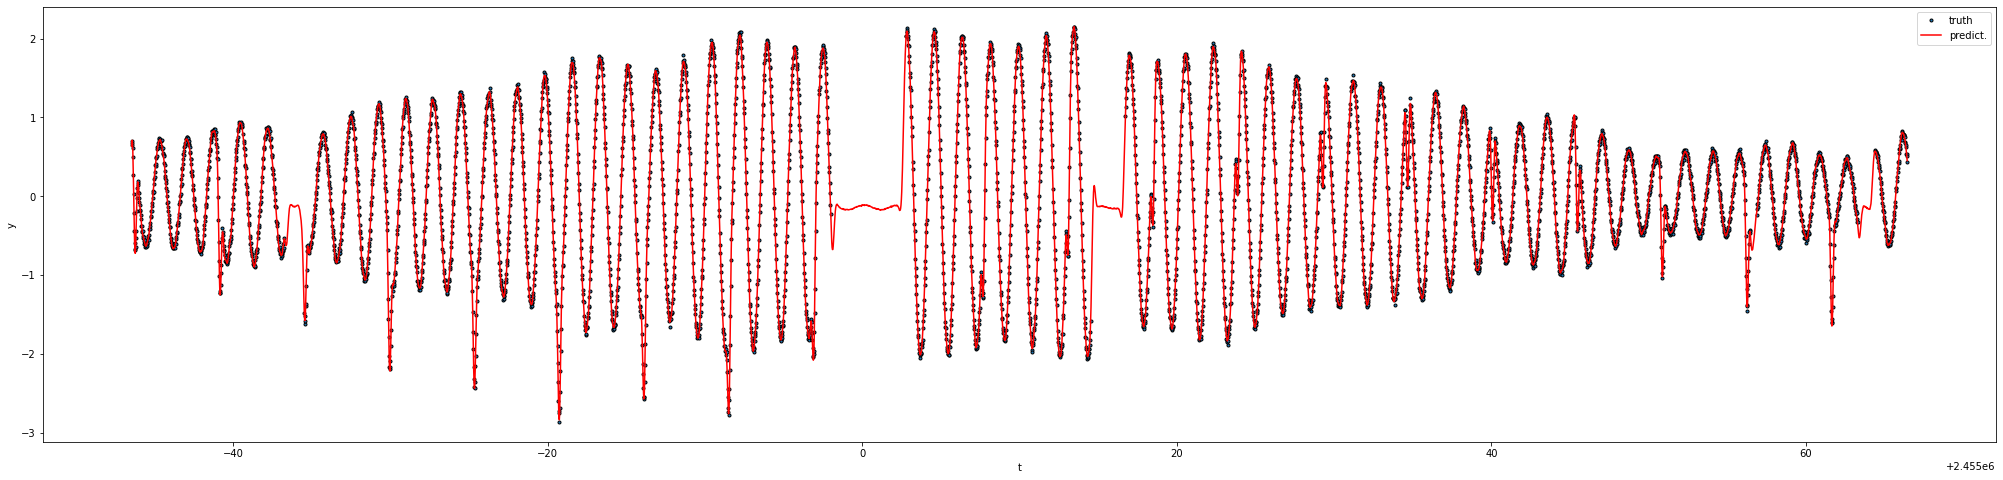

In [29]:
with torch.no_grad():
    plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part_smooth.cpu().numpy(), observed_pred.mean.cpu().numpy())

In [30]:
# Save the model if it's better than previous model
torch.save(model.state_dict(), '../models/time_series_gpytorch_eb_sm1.pth')

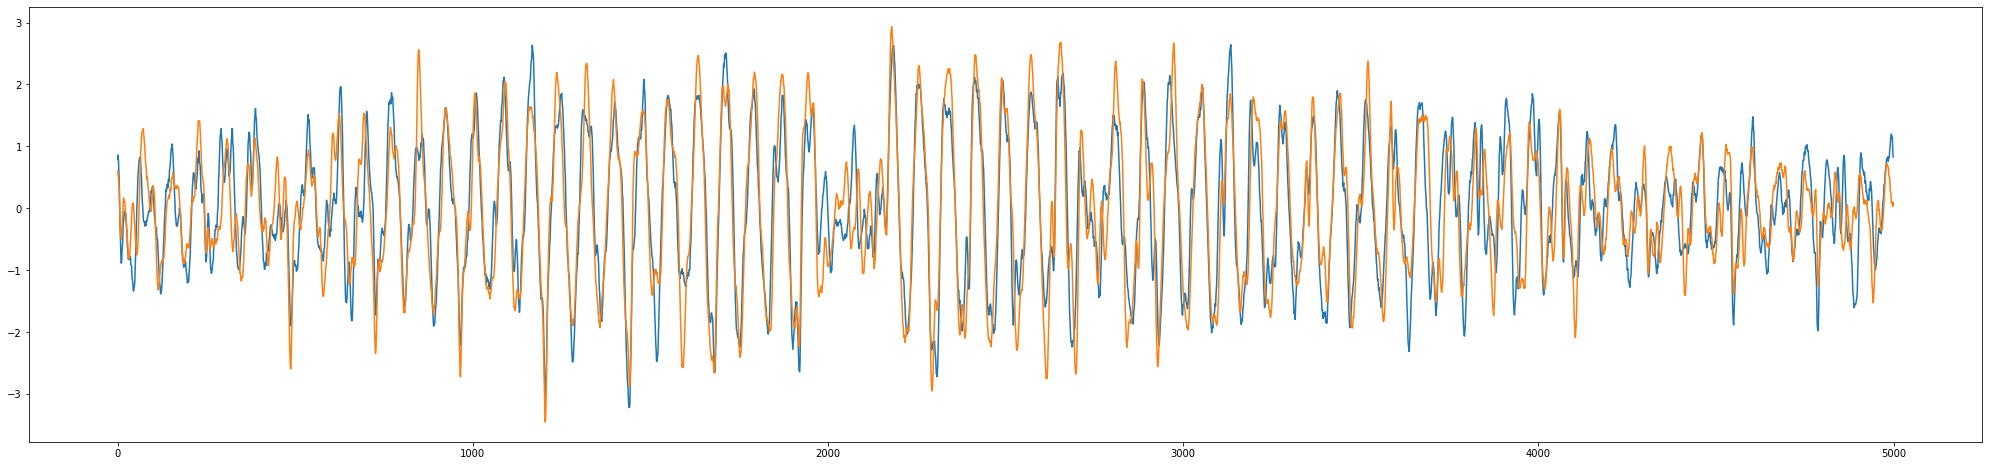

In [31]:
# Plot some samples of the kernel
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    plot_kernel_samples(model, X_part_smooth, nr_of_samples=2)

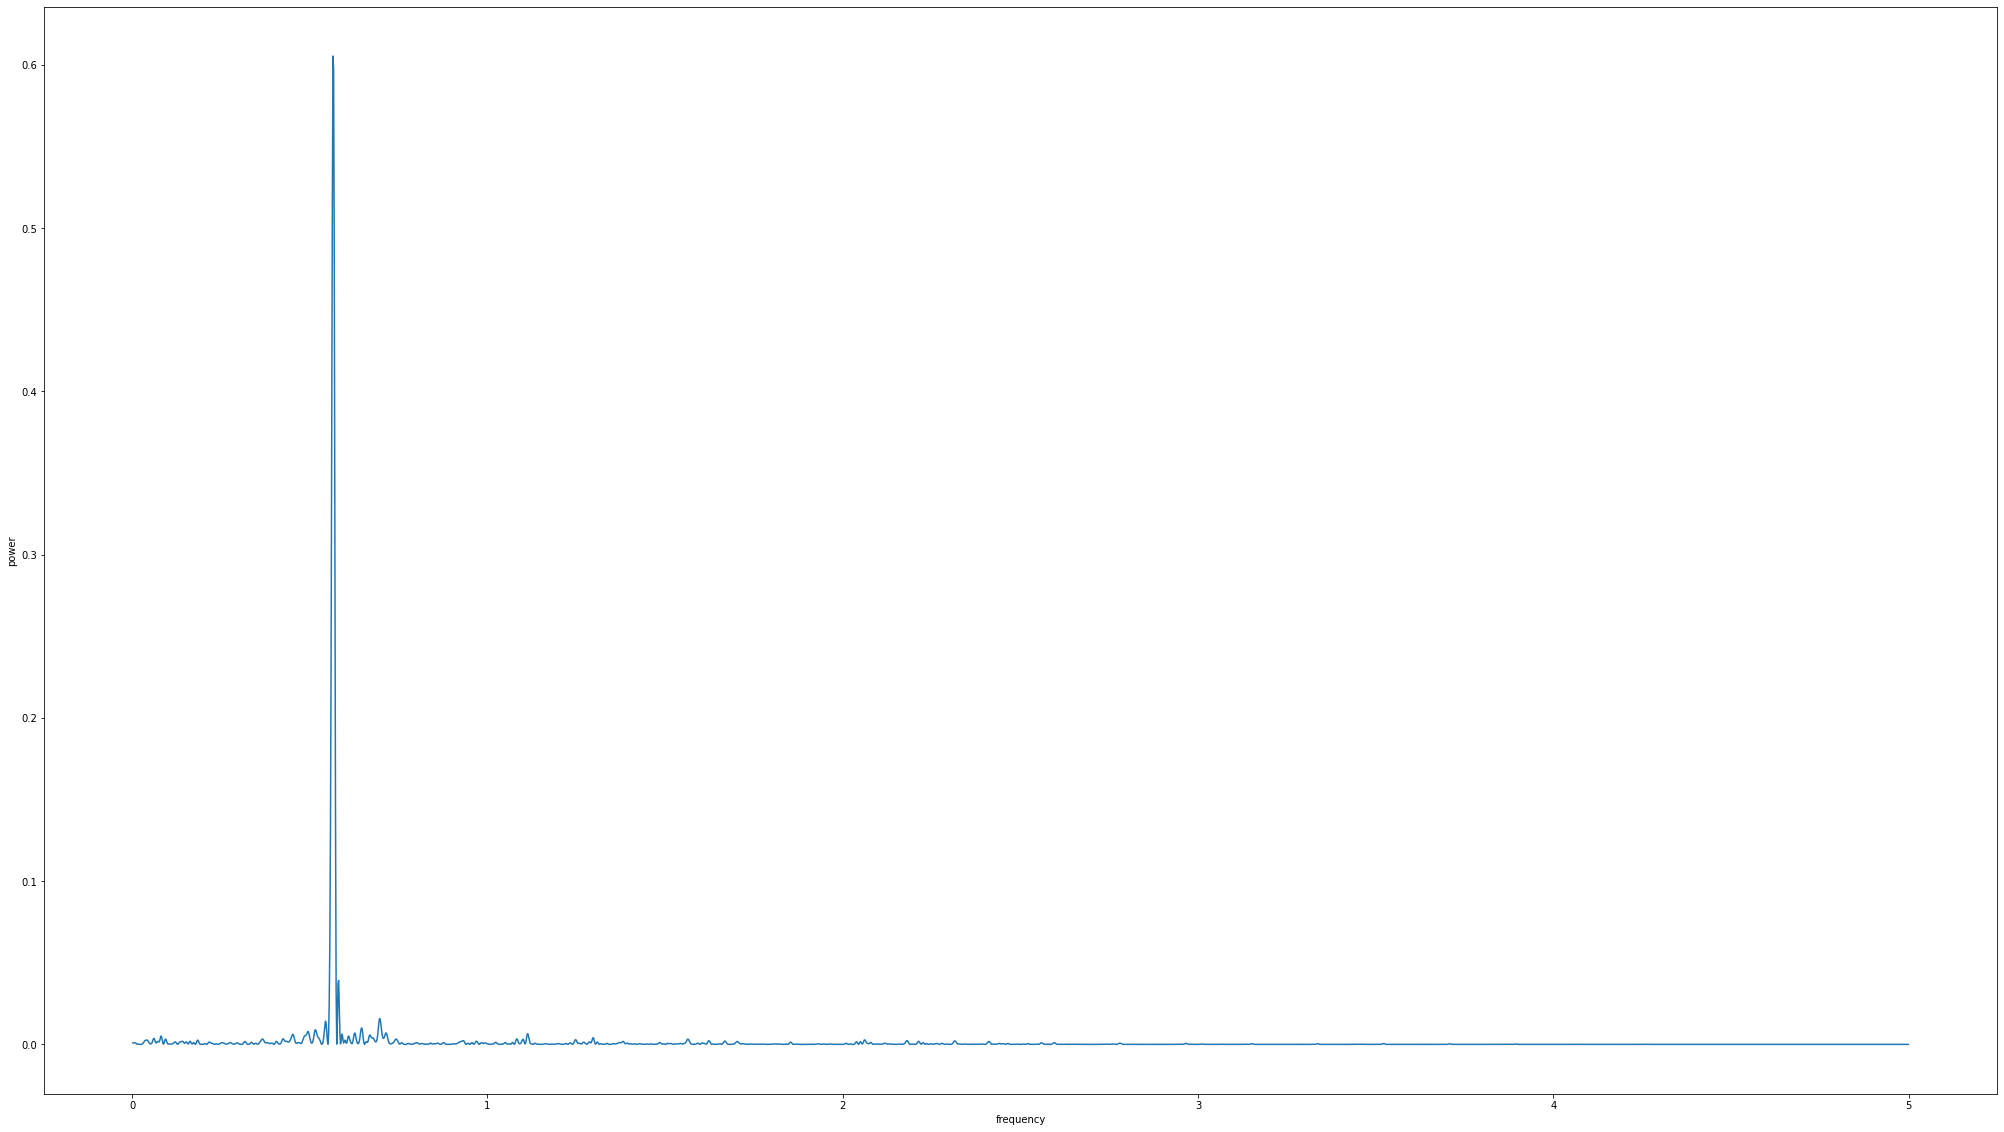

In [33]:
# Plot the periodogram of one sample
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_sample = model(X_part_smooth).sample()
    frequency, power = LombScargle(X_part_smooth, Y_sample).autopower(minimum_frequency=0.0, maximum_frequency=5)
    plt.figure(figsize=(35, 20))
    plt.plot(frequency, power)
    plt.xlabel("frequency"), plt.ylabel("power")

In [34]:
with torch.no_grad():
    scales = model.covar_module.mixture_scales.cpu().numpy().tolist()
    print("Mixture scales: ", scales.sort())
    print("Micture means:", model.covar_module.mixture_means.cpu().numpy())

Mixture scales:  None
Micture means: [[[13.72702261]]

 [[ 9.5758402 ]]

 [[10.48358974]]

 [[19.66572034]]

 [[ 3.99911062]]

 [[16.99464885]]

 [[26.10526134]]

 [[13.71067492]]

 [[20.30066482]]

 [[ 2.16664756]]

 [[19.00773631]]

 [[ 8.26525117]]

 [[ 0.93314573]]

 [[ 0.46821779]]

 [[11.13965941]]

 [[19.09355926]]

 [[21.01311746]]

 [[11.42452748]]

 [[13.83704447]]

 [[ 7.87969177]]

 [[16.38949771]]

 [[12.83399223]]

 [[ 5.01159269]]

 [[ 1.52500756]]

 [[11.84192608]]]


In [35]:
scales

[[[5.780798751931199e-05]],
 [[7.465593887405689e-05]],
 [[7.819736419639372e-05]],
 [[8.043235052022357e-05]],
 [[9.273050205870463e-05]],
 [[0.00010784018399544903]],
 [[0.00011138096454203352]],
 [[0.00014218440873774578]],
 [[0.00015469991926811945]],
 [[0.00017849792682515957]],
 [[0.0001942180183028098]],
 [[0.00020412140384829514]],
 [[0.00020851986884666256]],
 [[0.0002708930360466827]],
 [[0.00028412917808194783]],
 [[0.00033992876966681973]],
 [[0.0003442982499136319]],
 [[0.0003517195935989231]],
 [[0.00040190189974845]],
 [[0.0007691386907441432]],
 [[0.0008822620098438437]],
 [[0.004870763165606888]],
 [[0.005203578602107863]],
 [[0.005974844447038219]],
 [[1.0378699014450978]]]

In [36]:
with torch.no_grad():
    residuals = Y_part.cpu()-observed_pred.mean.cpu().numpy()

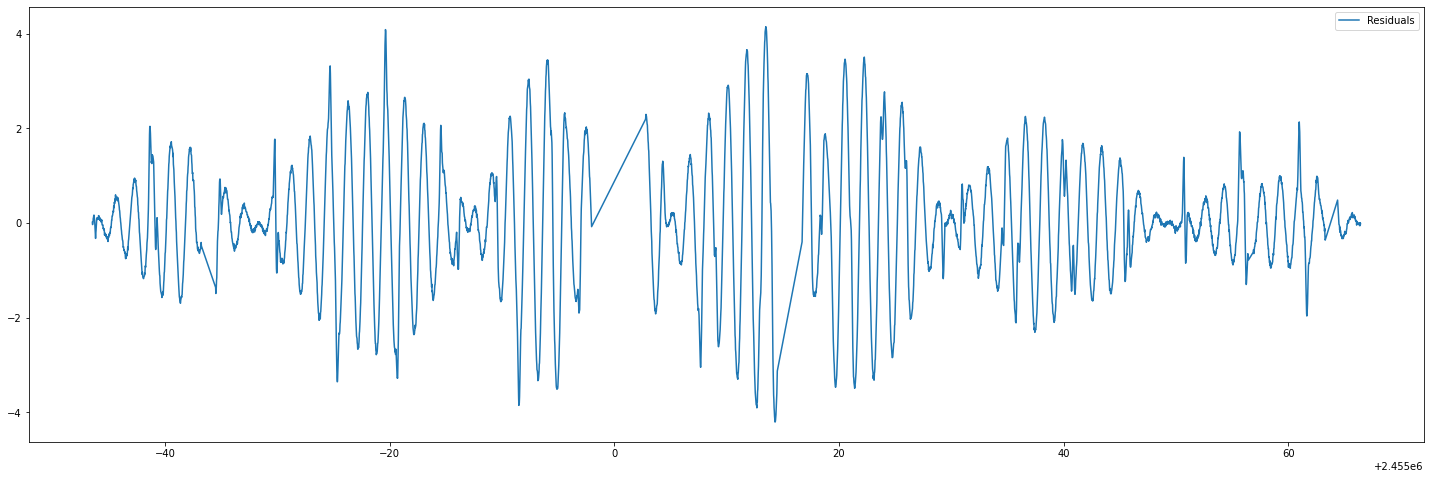

In [37]:
# Plot GP residuals
plt.figure(figsize=(25, 8))
plt.plot(X_part.cpu(), residuals, "-")
plt.legend(labels=["Residuals"])

### RMSE

In [38]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part))
    
np.sqrt(np.nanmean((observed_pred.mean.cpu().numpy()-Y_part.cpu().numpy())**2))

0.027489342365560613